In [ ]:
# STEP 0: Imports and small helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import connected_components, laplacian as csgraph_laplacian
from scipy.sparse import csr_matrix
from scipy.linalg import eigh
import networkx as nx

plt.rcParams["figure.figsize"] = (6.5, 5)
plt.rcParams["axes.grid"] = True

def scatter(X, title, c=None, s=28):
    """Simple 2D scatter with optional coloring."""
    plt.figure()
    plt.scatter(X[:,0], X[:,1], c=c, s=s)
    plt.title(title)
    plt.xlabel("Feature 1"); plt.ylabel("Feature 2")
    plt.tight_layout(); plt.show()

def overlay_graph(Xs, A_sparse, title):
    """Draw nodes at Xs and overlay graph edges from sparse adjacency."""
    # compatibility across networkx versions
    G = nx.from_scipy_sparse_array(A_sparse) if hasattr(nx, "from_scipy_sparse_array") else nx.from_scipy_sparse_matrix(A_sparse)
    pos = {i: (Xs[i,0], Xs[i,1]) for i in range(Xs.shape[0])}
    plt.figure(figsize=(6.5,5))
    nx.draw_networkx_nodes(G, pos, node_size=18, node_color="tab:blue")
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.35)
    plt.title(title); plt.axis("off"); plt.tight_layout(); plt.show()

def heatmap(A, title):
    """Visualize a (dense) matrix such as adjacency or similarity."""
    plt.figure(figsize=(6.2,5))
    plt.imshow(A, cmap="viridis", aspect="auto")
    plt.title(title); plt.colorbar(); plt.tight_layout(); plt.show()

Data source: Mall Customers, shape: (200, 2)


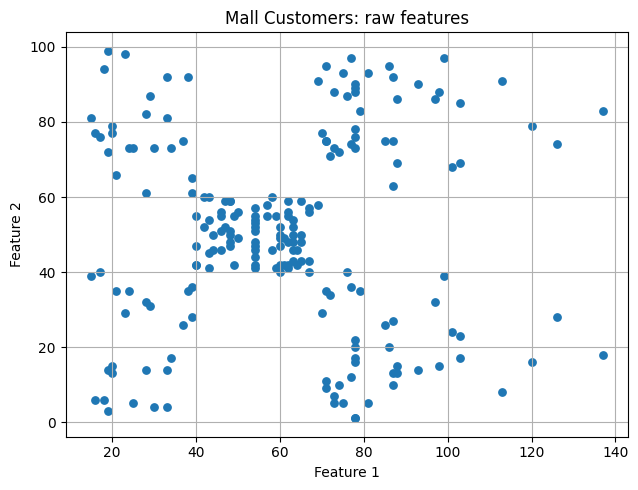

In [ ]:
# STEP 1: Load data (Mall Customers if present; otherwise synthetic)
CSV_PATH = "datasets/Mall_Customers.csv"

df = pd.read_csv(CSV_PATH)
X_df = df[['Annual Income (k$)', 'Spending Score (1-100)']].copy()
source = "Mall Customers"

X = X_df.values
print(f"Data source: {source}, shape: {X.shape}")
scatter(X, f"{source}: raw features")

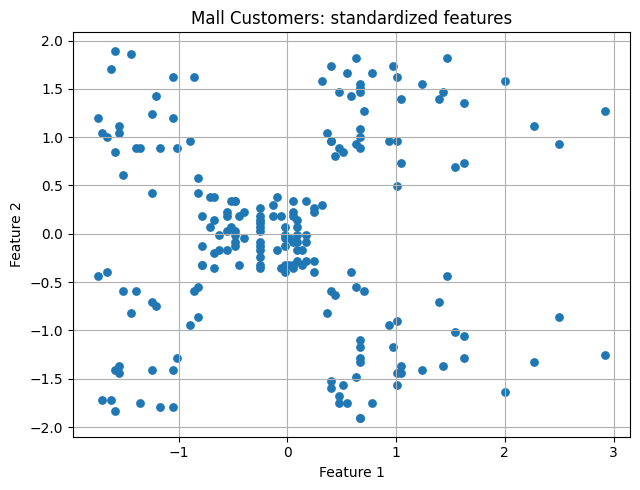

In [ ]:
# STEP 2: Standardize features so distances are fair
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
scatter(Xs, f"{source}: standardized features")

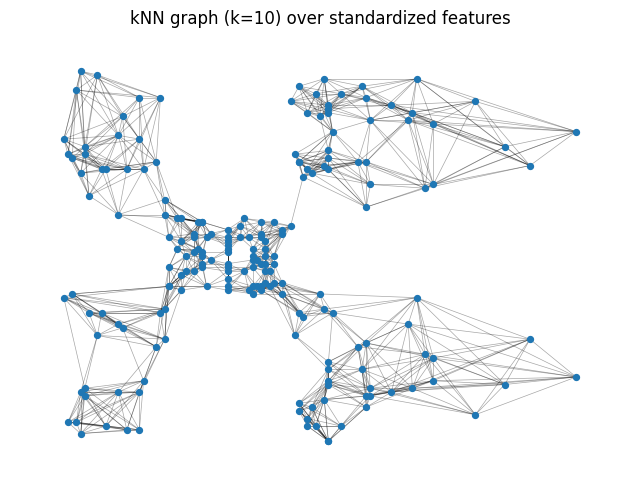

In [ ]:
# STEP 3: Build a symmetric kNN graph
k = 10  # try 6, 8, 10, 12, 15 to see different densities
A = kneighbors_graph(Xs, n_neighbors=k, mode="connectivity", include_self=False)
A = 0.5 * (A + A.T)  # symmetrize: undirected, 0/1 edges
overlay_graph(Xs, A, f"kNN graph (k={k}) over standardized features")

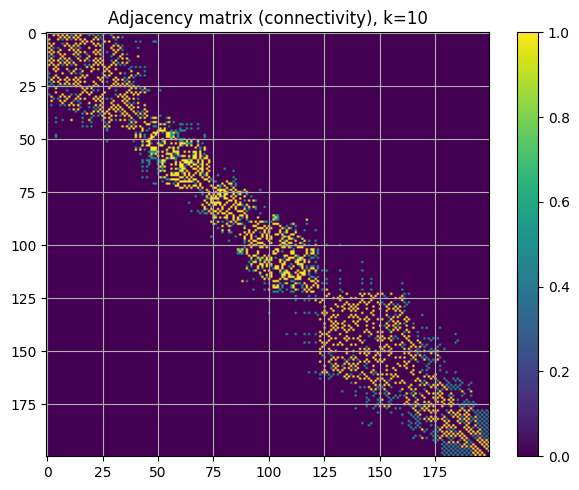

In [ ]:
# STEP 4: Inspect the adjacency matrix (0/1 connectivity)
heatmap(A.toarray(), f"Adjacency matrix (connectivity), k={k}")

Connected components: 1


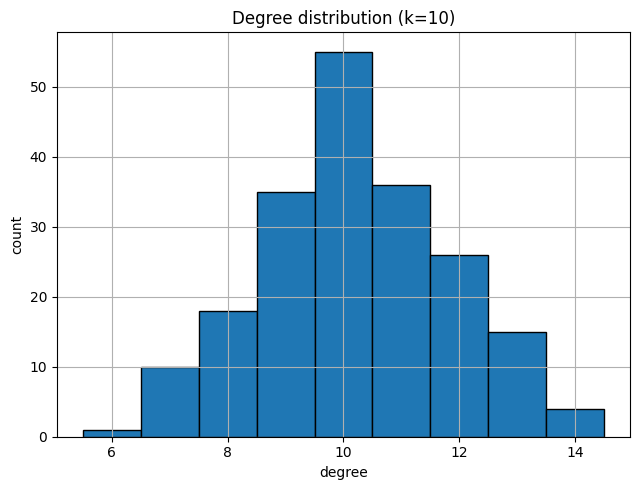

Average degree: 10.00 | min: 6.0 | max: 14.0


In [ ]:
# STEP 5: Connectivity and degree diagnostics
n_comp, comp_labels = connected_components(A, directed=False)
print(f"Connected components: {n_comp}")

degrees = np.array(A.sum(axis=1)).ravel()
plt.figure()
plt.hist(degrees, bins=np.arange(degrees.min(), degrees.max()+2)-0.5, edgecolor='k')
plt.title(f"Degree distribution (k={k})")
plt.xlabel("degree"); plt.ylabel("count")
plt.tight_layout(); plt.show()

print(f"Average degree: {degrees.mean():.2f} | min: {degrees.min()} | max: {degrees.max()}")

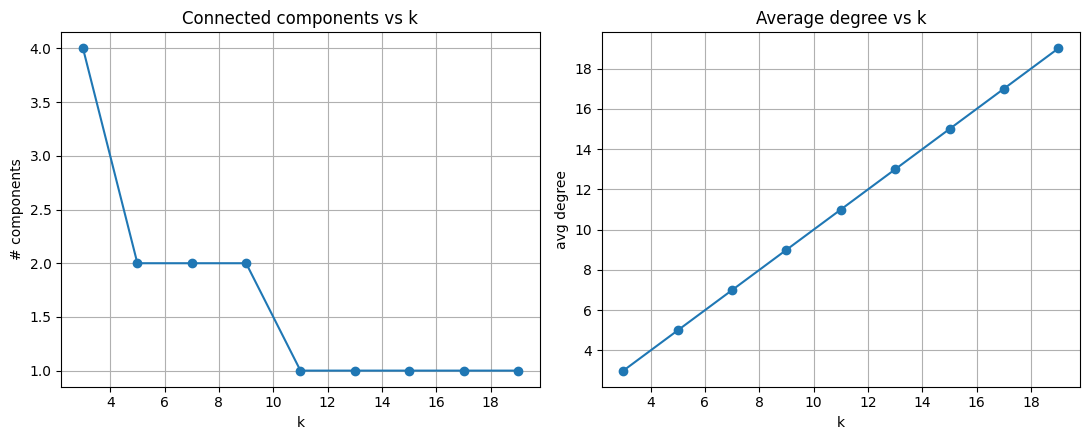

In [ ]:
# STEP 6: Sweep k to see how the graph changes
ks = list(range(3, 21, 2))  # 3,5,7,...,19
comp_counts, avg_degrees = [], []

for kk in ks:
    A_kk = kneighbors_graph(Xs, n_neighbors=kk, mode="connectivity", include_self=False)
    A_kk = 0.5 * (A_kk + A_kk.T)
    n_comp_kk, _ = connected_components(A_kk, directed=False)
    comp_counts.append(n_comp_kk)
    avg_degrees.append(np.array(A_kk.sum(axis=1)).mean())

fig, ax = plt.subplots(1, 2, figsize=(11, 4.5))
ax[0].plot(ks, comp_counts, marker='o')
ax[0].set_title("Connected components vs k")
ax[0].set_xlabel("k"); ax[0].set_ylabel("# components")

ax[1].plot(ks, avg_degrees, marker='o')
ax[1].set_title("Average degree vs k")
ax[1].set_xlabel("k"); ax[1].set_ylabel("avg degree")

plt.tight_layout(); plt.show()

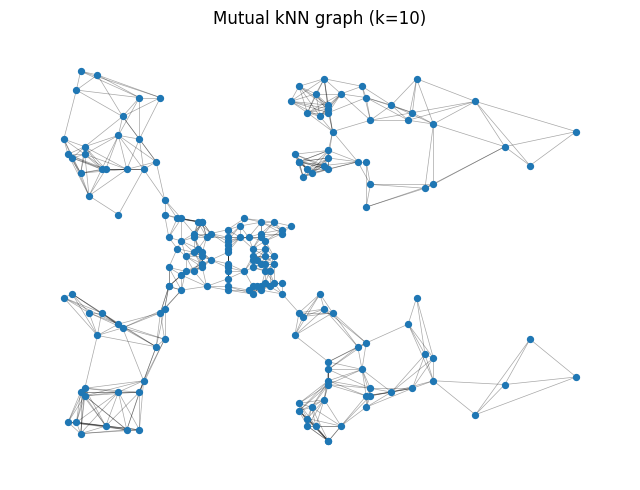

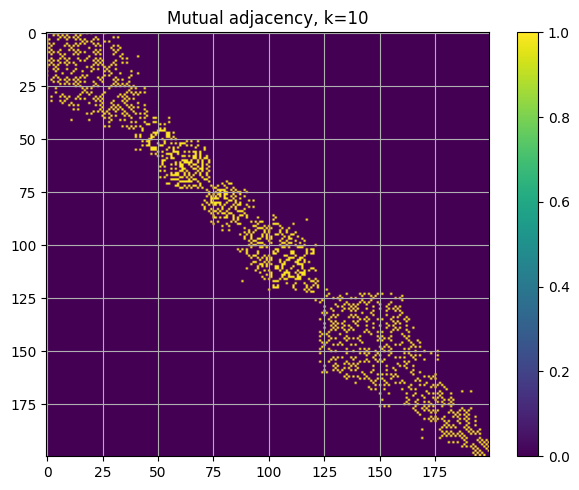

Mutual kNN components: 2 | avg degree: 7.76


In [ ]:
# STEP 7: Mutual kNN — keep edges only if i->j and j->i
A_dir = kneighbors_graph(Xs, n_neighbors=k, mode="connectivity", include_self=False)  # directed
A_mutual = A_dir.minimum(A_dir.T)  # intersection (reciprocal edges)
overlay_graph(Xs, A_mutual, f"Mutual kNN graph (k={k})")
heatmap(A_mutual.toarray(), f"Mutual adjacency, k={k}")

n_comp_mut, _ = connected_components(A_mutual, directed=False)
deg_mut = np.array(A_mutual.sum(axis=1)).ravel()
print(f"Mutual kNN components: {n_comp_mut} | avg degree: {deg_mut.mean():.2f}")

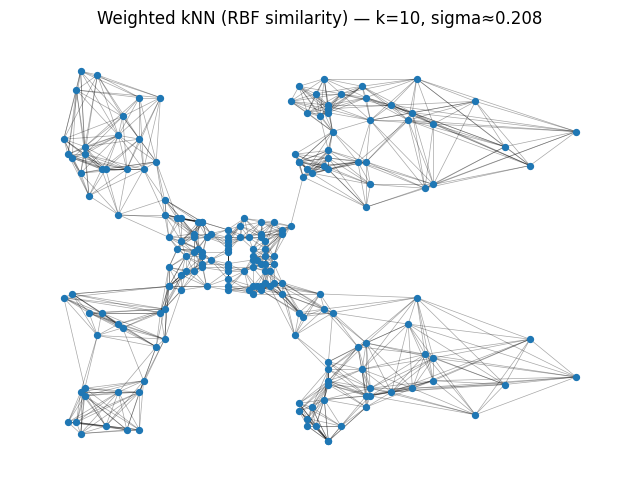

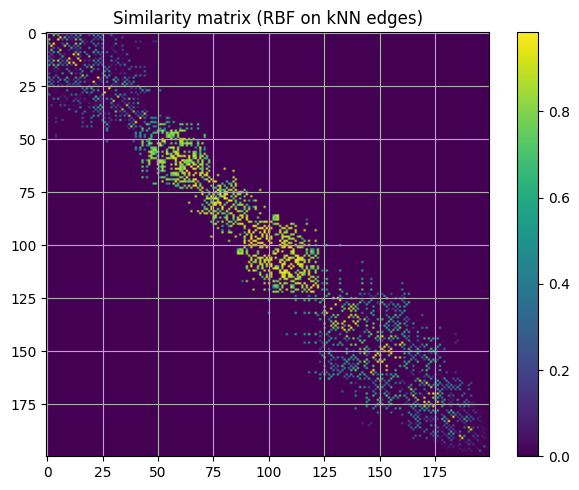

In [ ]:
# STEP 8: Weighted kNN (distance -> similarity via RBF)
A_dist = kneighbors_graph(Xs, n_neighbors=k, mode="distance", include_self=False)
A_dist = 0.5 * (A_dist + A_dist.T)  # symmetric distances

# Choose a scale (sigma) from the data: median neighbor distance is a robust default
dvals = A_dist.data
sigma = np.median(dvals) if dvals.size > 0 else 1.0

# Convert distances to similarities: sim = exp(-(d^2)/(2*sigma^2))
W_data = np.exp(-(dvals**2) / (2 * sigma**2))
A_sim = csr_matrix((W_data, A_dist.nonzero()), shape=A_dist.shape)

overlay_graph(Xs, A_sim, f"Weighted kNN (RBF similarity) — k={k}, sigma≈{sigma:.3f}")
heatmap(A_sim.toarray(), "Similarity matrix (RBF on kNN edges)")

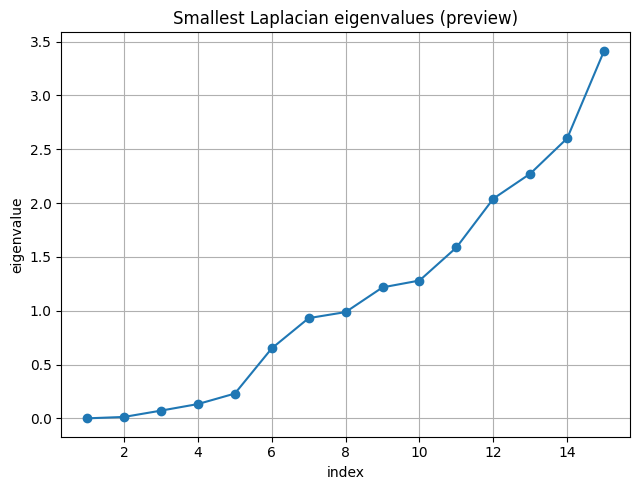

In [ ]:
# STEP 9: Graph Laplacian and smallest eigenvalues (preview)
L = csgraph_laplacian(A, normed=False)   # use the unweighted symmetric adjacency for clarity
w, _ = eigh(L.toarray())                 # eigenvalues ascending

m = min(15, len(w))
plt.figure()
plt.plot(range(1, m+1), w[:m], marker='o')
plt.title("Smallest Laplacian eigenvalues (preview)")
plt.xlabel("index"); plt.ylabel("eigenvalue")
plt.tight_layout(); plt.show()